In [22]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [23]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 100,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 100,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 100,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 100,5)

suitablearea_biomass = 2500 ## km2 
suitablearea_bgec = 2500 ## km2
suitablearea_msw = 2500 ## km2

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.524  buffer =  0.02524
radius_vspp_wind km =  0.8410000000000001  buffer =  0.00841
radius_spp_solar km =  1.3820000000000001  buffer =  0.01382
radius_vspp_solar km =  0.461  buffer =  0.00461


In [24]:
scenario_SI = 0
coarsenscale = 5
xr_out = xr.open_dataset('Output\\xr_output_all_SSI_' + str(scenario_SI) + "_CS_"+ str(coarsenscale)+ '_.nc')
print(xr_out)
try:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())
    print("cap_biomass = ",xr_out['cap_biomass'].sum())
    print("cap_bgec = ",xr_out['cap_bgec'].sum())
    print("cap_msw = ",xr_out['cap_msw'].sum())
except:
    print("cap_wind = ",xr_out['cap_wind'].sum())
    print("cap_solar = ",xr_out['cap_solar'].sum())

<xarray.Dataset> Size: 112MB
Dimensions:      (lat: 1069, lon: 597)
Coordinates:
  * lat          (lat) float64 9kB 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon          (lon) float64 5kB 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables:
    lccs_class   (lat, lon) int64 5MB ...
    SI_Biomass   (lat, lon) float64 5MB ...
    SI_Solar     (lat, lon) float64 5MB ...
    SI_Wind      (lat, lon) float64 5MB ...
    A_Biomass    (lat, lon) float64 5MB ...
    AVA_Wind     (lat, lon) float32 3MB ...
    AVA_Solar    (lat, lon) float32 3MB ...
    AVA_Biomass  (lat, lon) float64 5MB ...
    ADM1_EN      (lat, lon) <U24 61MB ...
    region       (lat, lon) <U2 5MB ...
    cap_wind     (lat, lon) float64 5MB ...
    cap_solar    (lat, lon) float64 5MB ...
cap_wind =  <xarray.DataArray 'cap_wind' ()> Size: 8B
array(25883.145)
cap_solar =  <xarray.DataArray 'cap_solar' ()> Size: 8B
array(1220076.)
cap_wind =  <xarray.DataArray 'cap_wind' ()> Size: 8B
array(25883.145)
cap_sol

In [25]:
try:
    df_wind = xr_out.to_dataframe()
    xr_out.close()
    df_wind.reset_index(inplace=True)
    df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
    df_wind.crs = {'init': 'epsg:4326'}
    print(len(df_wind))
    for i,c in enumerate(df_wind.columns):
        if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_wind','AVA_Wind','geometry']):
            df_wind = df_wind.drop(columns=c)

    df_wind = df_wind.loc[df_wind['cap_wind'] > 0]
    df_wind.reset_index(inplace=True,drop=False)
    df_wind.crs = {'init': 'epsg:4326'}
    df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)
    df_wind = df_wind.set_geometry('buffer')

    df_wind.to_csv('Output\\Output_wind_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_wind)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193
       index        lat         lon   SI_Wind  AVA_Wind     ADM1_EN region  \
0      31310   6.343056  101.045833  0.507800      0.90        Yala     R3   
1      31906   6.356944  101.031944  0.511859      0.90        Yala     R3   
2      31907   6.356944  101.045833  0.050393      0.09        Yala     R3   
3      31914   6.356944  101.143056  0.237255      0.45        Yala     R3   
4      31915   6.356944  101.156944  0.226208      0.45        Yala     R3   
...      ...        ...         ...       ...       ...         ...    ...   
4687  614544  19.912500  100.559722  0.733388      1.71  Chiang Rai     R4   
4688  614545  19.912500  100.573611  0.037117      0.09  Chiang Rai     R4   
4689  615110  19.926389  100.129167  1.402229      2.25  Chiang Rai     R4   
4690  615140  19.926389  100.545833  0.110012      0.27  Chiang Rai     R4   
4691  615141  19.926389  100.559722  0.523765      1.26  Chiang Rai     R4   

      cap_wind                    geometry  \
0        4

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_13248\1157218713.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind['buffer'] = df_wind['geometry'].buffer(np.round(np.sqrt(df_wind['cap_wind']/(mwperkm2_wind * 3.14)) / 100,5),cap_style = 3)


In [26]:
try:
    df_solar = xr_out.to_dataframe()
    df_solar.reset_index(inplace=True)
    df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
    df_solar.crs = {'init': 'epsg:4326'}
    print(len(df_solar))
    for i,c in enumerate(df_solar.columns):
        if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_solar','AVA_Solar','geometry']):
            df_solar = df_solar.drop(columns=c)

    df_solar = df_solar.loc[df_solar['cap_solar'] > 0]
    df_solar.reset_index(inplace=True,drop=False)
    df_solar.crs = {'init': 'epsg:4326'}
    df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)
    df_solar = df_solar.set_geometry('buffer')

    df_solar.to_csv('Output\\Output_solar_all_SSI_' + str(scenario_SI) + "_CS_" + str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_solar)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_13248\3812903428.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar['buffer'] = df_solar['geometry'].buffer(np.round(np.sqrt(df_solar['cap_solar']/(mwperkm2_solar * 3.14)) / 100,5),cap_style = 3)


        index        lat         lon  SI_Solar  AVA_Solar     ADM1_EN region  \
0        8631   5.815278  101.143056  0.063453       0.09        Yala     R3   
1       12265   5.898611  101.865278  0.626819       0.63  Narathiwat     R3   
2       12266   5.898611  101.879167  0.732460       0.72  Narathiwat     R3   
3       12861   5.912500  101.851389  0.236434       0.27  Narathiwat     R3   
4       12862   5.912500  101.865278  0.080546       0.09  Narathiwat     R3   
...       ...        ...         ...       ...        ...         ...    ...   
93994  635405  20.398611  100.087500  0.299122       0.36  Chiang Rai     R4   
93995  635406  20.398611  100.101389  1.501338       1.62  Chiang Rai     R4   
93996  635407  20.398611  100.115278  0.732103       0.81  Chiang Rai     R4   
93997  636003  20.412500  100.101389  0.480349       0.54  Chiang Rai     R4   
93998  636004  20.412500  100.115278  1.319948       1.44  Chiang Rai     R4   

       cap_solar                    geo

In [27]:
try:
    df_biomass = xr_out.to_dataframe()
    df_biomass.reset_index(inplace=True)
    df_biomass = gpd.GeoDataFrame(df_biomass, geometry =gpd.points_from_xy(df_biomass['lon'],df_biomass['lat']))
    df_biomass.crs = {'init': 'epsg:4326'}
    print(len(df_biomass))
    for i,c in enumerate(df_biomass.columns):
        if c not in (['lon','lat','SI_Biomass','SI_Biomass_max','SI_Biomass_min','region','ADM1_EN','cap_biomass','geometry']):
            df_biomass = df_biomass.drop(columns=c)

    df_biomass = df_biomass.loc[df_biomass['cap_biomass'] > 0]
    df_biomass.reset_index(inplace=True,drop=False)
    df_biomass.crs = {'init': 'epsg:4326'}
    df_biomass['buffer'] = df_biomass['geometry'].buffer(np.round(np.sqrt(suitablearea_biomass/(3.14)) / 150,5),cap_style = 3)
    df_biomass = df_biomass.set_geometry('buffer')

    df_biomass.to_csv('Output\\Output_biomass_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_biomass)
    
except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


In [28]:
try:
    df_bgec = xr_out.to_dataframe()
    df_bgec.reset_index(inplace=True)
    df_bgec = gpd.GeoDataFrame(df_bgec, geometry =gpd.points_from_xy(df_bgec['lon'],df_bgec['lat']))
    df_bgec.crs = {'init': 'epsg:4326'}
    print(len(df_bgec))
    for i,c in enumerate(df_bgec.columns):
        if c not in (['lon','lat','SI_BGEC','SI_BGEC_max','SI_BGEC_min','region','ADM1_EN','cap_bgec','geometry']):
            df_bgec = df_bgec.drop(columns=c)

    df_bgec = df_bgec.loc[df_bgec['cap_bgec'] > 0]
    df_bgec.reset_index(inplace=True,drop=False)
    df_bgec.crs = {'init': 'epsg:4326'}
    df_bgec['buffer'] = df_bgec['geometry'].buffer(np.round(np.sqrt(suitablearea_bgec/(3.14)) / 150,5),cap_style = 3)
    df_bgec = df_bgec.set_geometry('buffer')

    df_bgec.to_csv('Output\\Output_bgec_all_SSI_' + str(scenario_SI) + "_CS_"+str(coarsenscale)+ '.csv',index=False,encoding="utf-8-sig")

    print(df_bgec)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


In [29]:
try: 
    df_msw = xr_out.to_dataframe()
    df_msw.reset_index(inplace=True)
    df_msw = gpd.GeoDataFrame(df_msw, geometry =gpd.points_from_xy(df_msw['lon'],df_msw['lat']))
    df_msw.crs = {'init': 'epsg:4326'}
    print(len(df_msw))
    for i,c in enumerate(df_msw.columns):
        if c not in (['lon','lat','SI_MSW','SI_MSW_max','SI_MSW_min','region','ADM1_EN','cap_msw','geometry']):
            df_msw = df_msw.drop(columns=c)

    df_msw = df_msw.loc[df_msw['cap_msw'] > 0]
    df_msw.reset_index(inplace=True,drop=False)
    df_msw.crs = {'init': 'epsg:4326'}
    df_msw['buffer'] = df_msw['geometry'].buffer(np.round(np.sqrt(suitablearea_msw/(3.14)) / 150,5),cap_style = 3)
    df_msw = df_msw.set_geometry('buffer')

    df_msw.to_csv('Output\\Output_msw_all_SSI_' + str(scenario_SI) + "_CS_" +str(coarsenscale) + '.csv',index=False,encoding="utf-8-sig")

    print(df_msw)

except:
    None

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  25883.145000000004
R0 wind =  0.0
R1 wind =  4243.995000000001
R2 wind =  6102.135
R3 wind =  13061.25
R4 wind =  2475.7650000000003


(array([1105.,  762.,  510.,  395.,  297.,  239.,  180.,  201.,  235.,
         391.,  316.,   61.]),
 array([0.02828556, 0.24002205, 0.45175854, 0.66349503, 0.87523152,
        1.08696801, 1.29870451, 1.510441  , 1.72217749, 1.93391398,
        2.14565047, 2.35738696, 2.56912345]),
 <BarContainer object of 12 artists>)

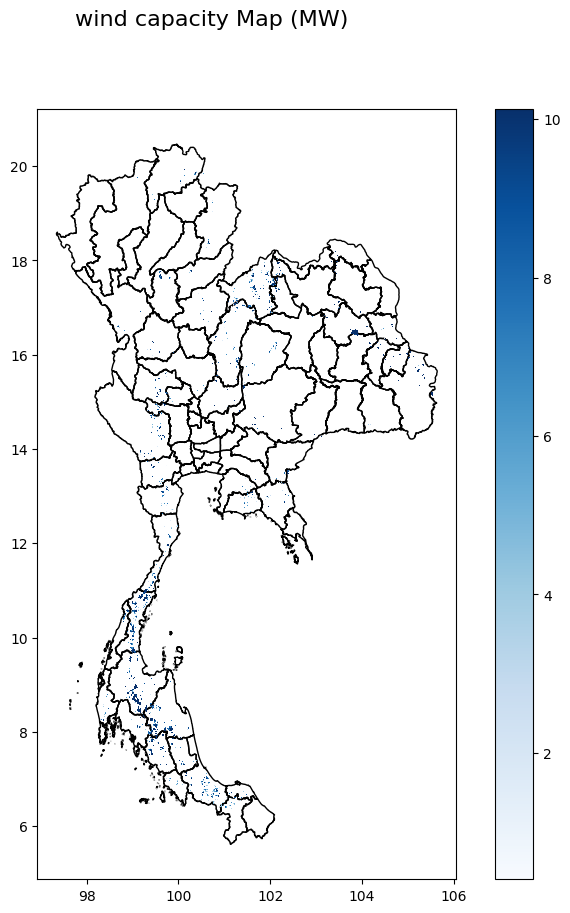

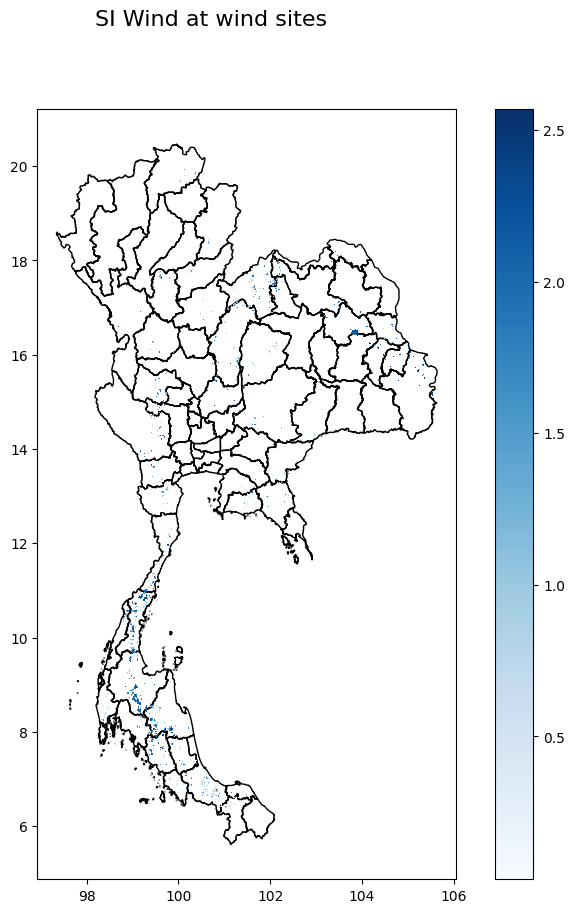

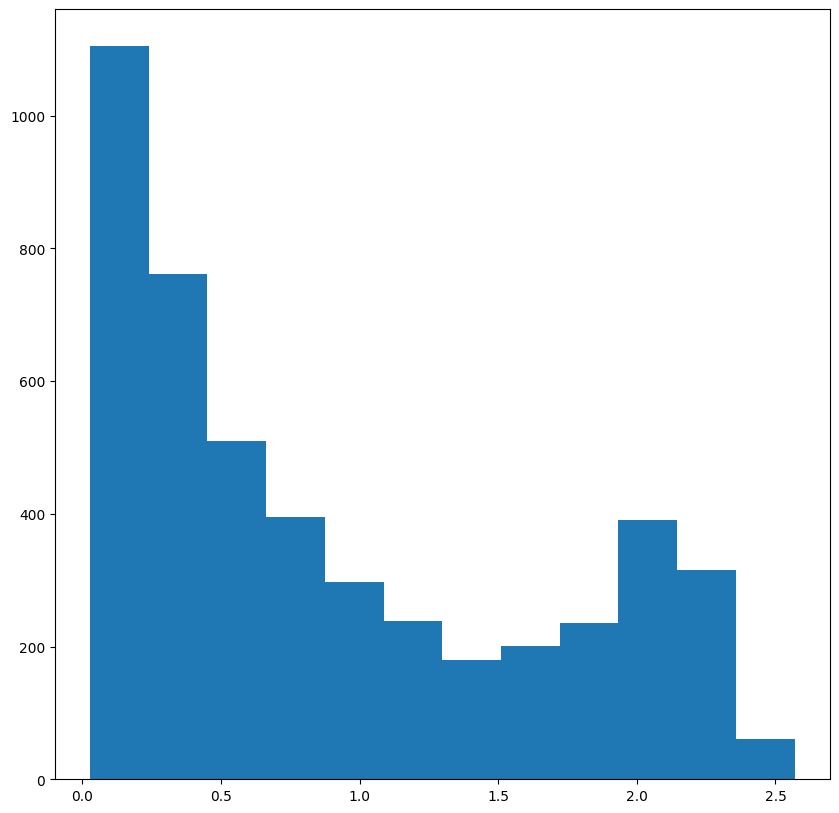

In [30]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind['cap_wind'].sum())
print("R0 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R0'].sum())
print("R1 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R1'].sum())
print("R2 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R2'].sum())
print("R3 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R3'].sum())
print("R4 wind = ",df_wind['cap_wind'].loc[df_wind['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('wind capacity Map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'cap_wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Wind at wind sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_wind['SI_Wind'],histtype ='barstacked',bins=12)

total solar capacity =  1220076.0
R0 Solar =  5760.45
R1 Solar =  255090.59999999998
R2 Solar =  530180.1
R3 Solar =  140209.65
R4 Solar =  288835.2


(array([23603., 15720., 11246.,  8396.,  6650.,  5509.,  4670.,  3953.,
         3936.,  5439.,  4589.,   288.]),
 array([0.04896562, 0.27119314, 0.49342065, 0.71564817, 0.93787569,
        1.1601032 , 1.38233072, 1.60455824, 1.82678576, 2.04901327,
        2.27124079, 2.49346831, 2.71569582]),
 <BarContainer object of 12 artists>)

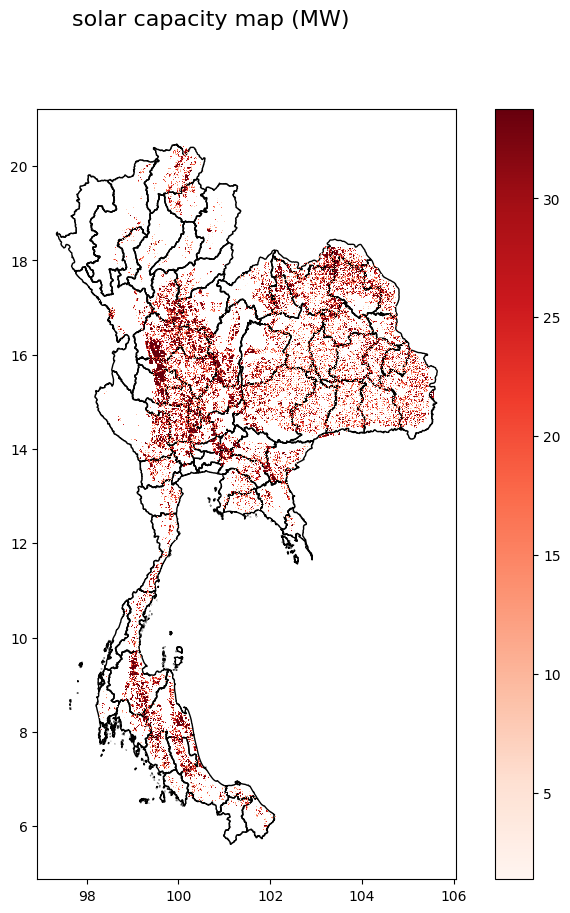

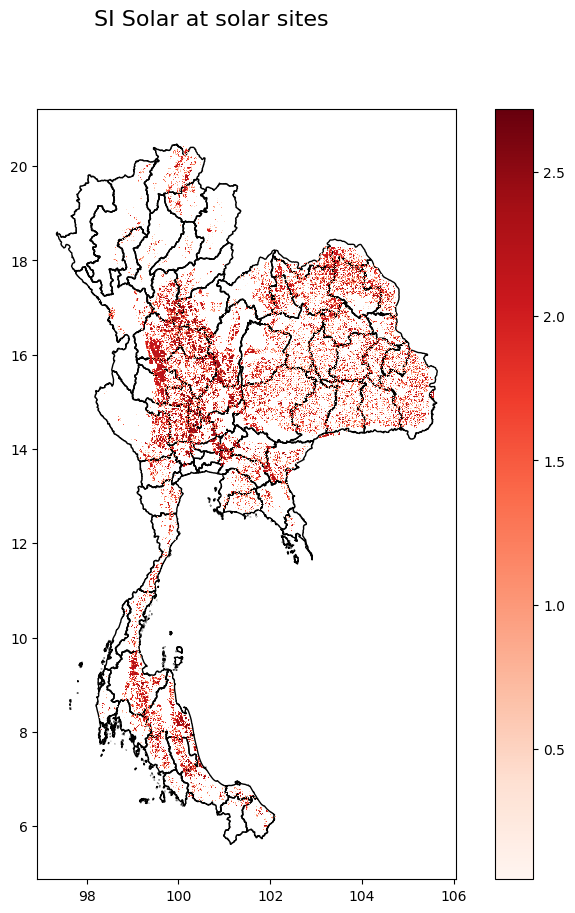

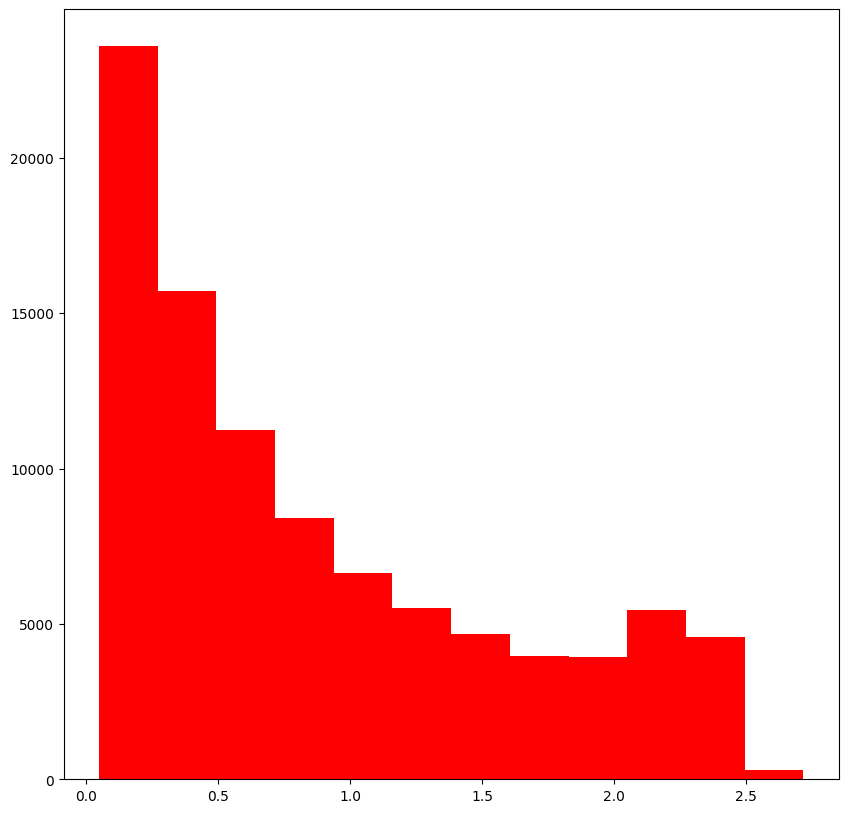

In [31]:
print("total solar capacity = ", df_solar['cap_solar'].sum())
print("R0 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R0'].sum())
print("R1 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R1'].sum())
print("R2 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R2'].sum())
print("R3 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R3'].sum())
print("R4 Solar = ",df_solar['cap_solar'].loc[df_solar['region'] == 'R4'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('solar capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'cap_solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SI Solar at solar sites', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar.plot(ax = ax,legend=True,zorder = 1,column = 'SI_Solar',cmap = 'Reds')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
plt.hist(df_solar['SI_Solar'],histtype ='barstacked',bins=12,color='red')

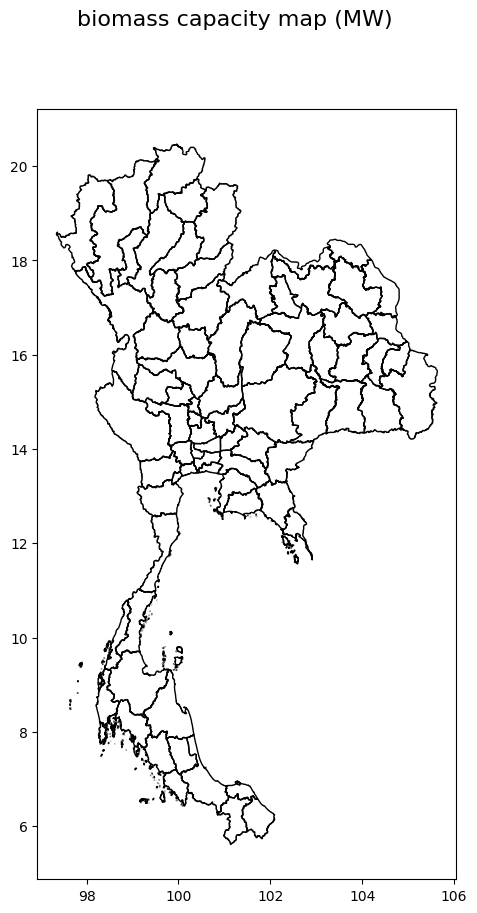

In [32]:
try:
    print("total biomass capacity = ", df_biomass['cap_biomass'].sum())
    print("R0 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R0'].sum())
    print("R1 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R1'].sum())
    print("R2 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R2'].sum())
    print("R3 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R3'].sum())
    print("R4 biomass = ",df_biomass['cap_biomass'].loc[df_biomass['region'] == 'R4'].sum())
except:
    None
    
fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('biomass capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_biomass.plot(ax = ax,legend=True,zorder = 1,column = 'cap_biomass',cmap = 'Greens')
except:
    None

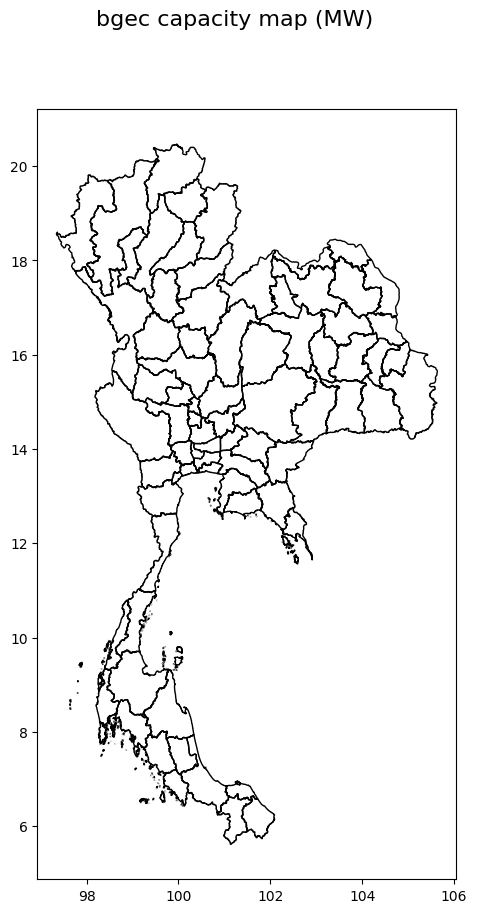

In [33]:
try:
    print("total bgec capacity = ", df_bgec['cap_bgec'].sum())
    print("R0 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R0'].sum())
    print("R1 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R1'].sum())
    print("R2 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R2'].sum())
    print("R3 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R3'].sum())
    print("R4 bgec = ",df_bgec['cap_bgec'].loc[df_bgec['region'] == 'R4'].sum())
    
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('bgec capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_bgec.plot(ax = ax,legend=True,zorder = 1,column = 'cap_bgec',cmap = 'Purples')
except:
    None

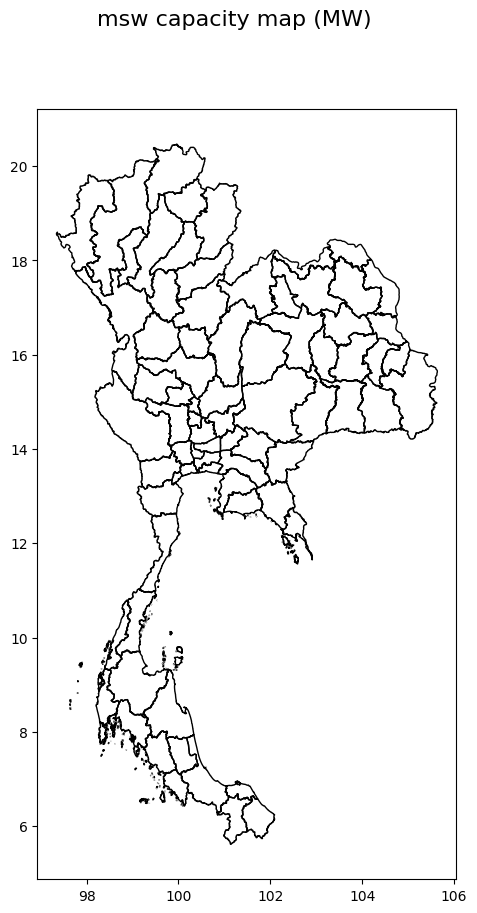

In [34]:
try:
    print("total msw capacity = ", df_msw['cap_msw'].sum())
    print("R0 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R0'].sum())
    print("R1 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R1'].sum())
    print("R2 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R2'].sum())
    print("R3 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R3'].sum())
    print("R4 msw = ",df_msw['cap_msw'].loc[df_msw['region'] == 'R4'].sum())
except:
    None

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('msw capacity map (MW)', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_msw.plot(ax = ax,legend=True,zorder = 1,column = 'cap_msw',cmap = 'Greys')
except:
    None

In [35]:
region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
list_region = []
count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
thailandmap['region'] = list_region

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


C:\Users\595078\AppData\Local\Temp\ipykernel_13248\3520815435.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bound = specificarea.unary_union.bounds


total wind capacity =  4243.995000000001
total solar capacity =  255090.59999999998


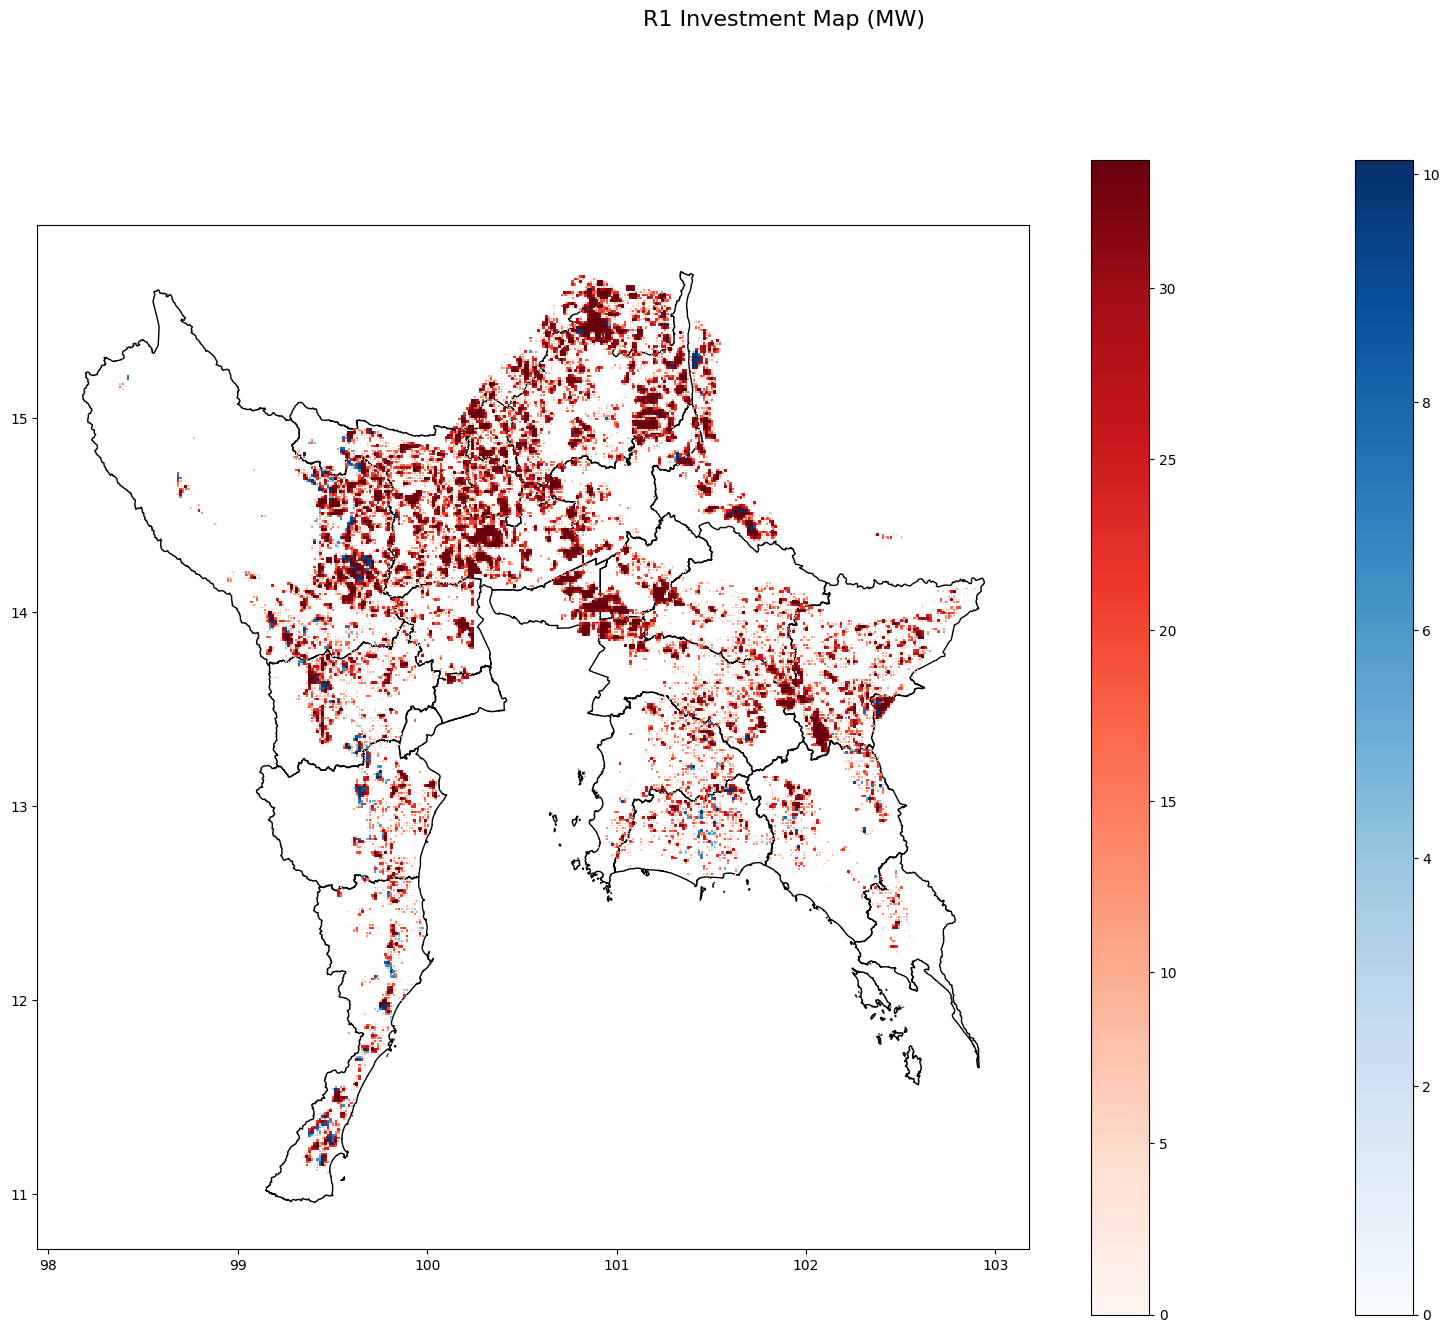

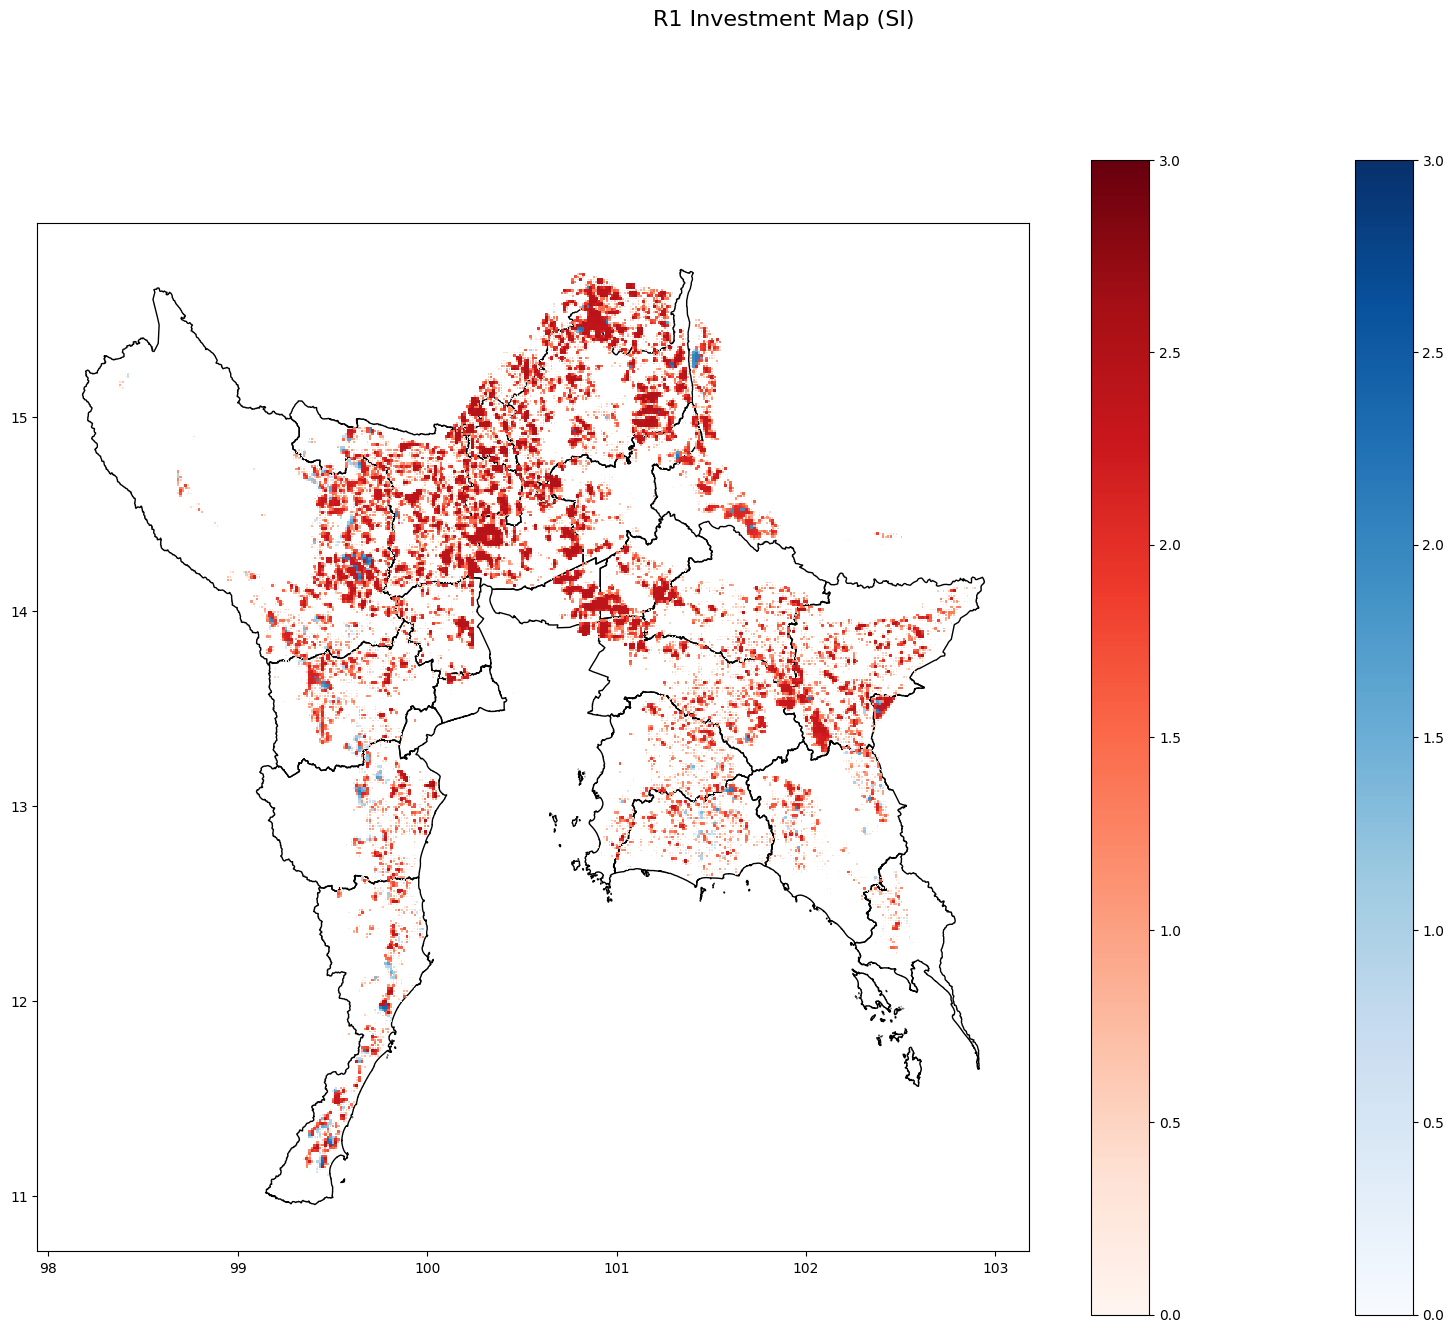

In [36]:
region = 'R1'
specificarea = thailandmap.loc[thailandmap['region'] == region]
bound = specificarea.unary_union.bounds
try:
    print("total wind capacity = ", df_wind['cap_wind'].loc[df_wind['region'] == region].sum())

    print("total solar capacity = ", df_solar['cap_solar'].loc[df_solar['region'] == region].sum())

    print("total biomass capacity = ", df_biomass['cap_biomass'].loc[df_biomass['region'] == region].sum())

    print("total bgec capacity = ", df_bgec['cap_bgec'].loc[df_bgec['region'] == region].sum())

    print("total msw capacity = ", df_msw['cap_msw'].loc[df_msw['region'] == region].sum())

except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (MW) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend = True,zorder = 1,column = 'cap_wind',cmap = 'Blues',vmin = 0)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend = True,zorder = 2,column = 'cap_solar',cmap = 'Reds',vmin = 0)
except:
    None
try:
    df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend = True,zorder = 3,column = 'cap_biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0)
except:
    None
try:
    df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend = True,zorder = 4,column = 'cap_bgec',cmap = 'Purples',edgecolors = 'purple',vmin = 0)
except:
    None
try:
    df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend = True,zorder = 5,column = 'cap_msw',cmap = 'Greys',edgecolors = 'grey',vmin = 0)
except:
    None

fig, ax = plt.subplots(figsize=(20,15))
fig.suptitle(region + ' Investment Map (SI) ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind.loc[df_wind['region'] == region].plot(ax = ax,legend=True,zorder = 1,column = 'SI_Wind',cmap = 'Blues',vmin = 0,vmax=3)
except:
    None
try:
    df_solar.loc[df_solar['region'] == region].plot(ax = ax,legend=True,zorder = 2,column = 'SI_Solar',cmap = 'Reds',vmin = 0,vmax=3)
except:
    None
# try:
#     df_biomass.loc[df_biomass['region'] == region].plot(ax = ax,legend=True,zorder = 3,column = 'SI_Biomass',cmap = 'Greens',edgecolors = 'green',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_bgec.loc[df_bgec['region'] == region].plot(ax = ax,legend=True,zorder = 4,column = 'SI_BGEC',cmap = 'Purples',edgecolors = 'purple',vmin = 0,vmax=3)
# except:
#     None
# try:
#     df_msw.loc[df_msw['region'] == region].plot(ax = ax,legend=True,zorder = 5,column = 'SI_MSW',cmap = 'Greys',edgecolors = 'grey',vmin = 0,vmax=3)
# except:
#     None